## Description:

    Use DeSeq2 to identify OTUs that are correlated with inorganic N concentration


# Setting variables

In [2]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/'
#using physeq file with sparsity of greater than 3 in 3 samples
physeqFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3'

# Init

In [1]:
%load_ext rpy2.ipython

In [3]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "metagenomeSeq", "phyloseq", "dplyr", "tidyr", 
           "reshape", "vegan")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.4’
[1] "BiocParallel"
[1] ‘1.4.3’
[1] "doParallel"
[1] ‘1.0.10’
[1] "DESeq2"
[1] ‘1.10.1’
[1] "foreach"
[1] ‘1.4.3’
[1] "ggplot2"
[1] ‘2.1.0’
[1] "gridExtra"
[1] ‘2.2.1’
[1] "scales"
[1] ‘0.4.0’
[1] "metagenomeSeq"
[1] ‘1.12.1’
[1] "phyloseq"
[1] ‘1.14.0’
[1] "dplyr"
[1] ‘0.5.0’
[1] "tidyr"
[1] ‘0.5.1’
[1] "reshape"
[1] ‘0.8.5’
[1] "vegan"
[1] ‘2.4.0’


In [5]:
%%R
register(MulticoreParam(20))

# Loading phyloseq object

In [6]:
%%R -i physeqFile

physeq.Full = readRDS(physeqFile)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


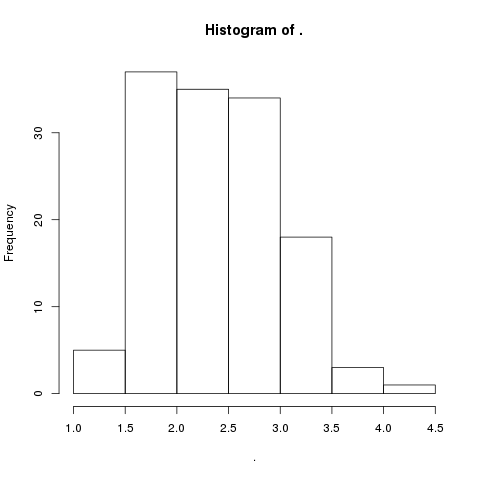

In [97]:
%%R
sample_data(physeq.Full)$InorganicN %>% log() %>% hist

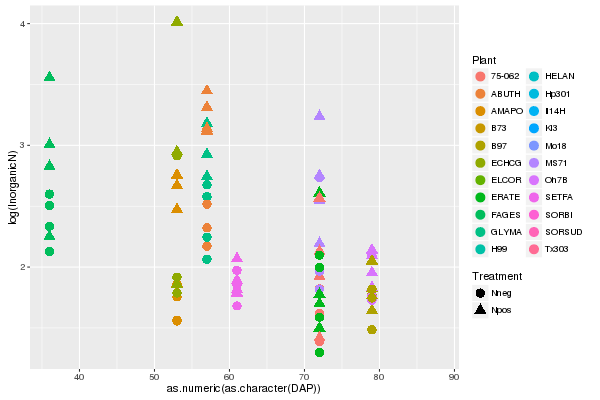

In [98]:
%%R -w 600 -h 400
sd = sample_data(physeq.Full)
sd = filter(sd, Plant != "BARE")
p = ggplot(sd, aes(x = as.numeric(as.character(DAP)), y = log(InorganicN), color = Plant, shape = Treatment)) + 
           geom_point(size = 4)
p 

In [43]:
%%R
sd %>% filter(InorganicN > 50) %>% .[,c("Plant", "Plot")]

  Plant Plot
1 ECHCG 1.24


### Notes:
* High inorganic N outlier will weight analysis.  Remove before proceeding. 

In [106]:
%%R

#Set DAP as factor
sample_data(physeq.Full)$DAP = factor(sample_data(physeq.Full)$DAP) 
sample_data(physeq.Full)$Rep = factor(sample_data(physeq.Full)$Rep) 
sample_data(physeq.Full)$DAP %>% levels

#sample_data(physeq.Full)$PlantRep = interaction(sample_data(physeq.Full)$Rep, sample_data(physeq.Full)$Plant)

# remove inorganic N outliers
p = subset_samples(physeq.Full, InorganicN < 50)
#p = subset_samples(physeq.Full, !is.na(InorganicN))

physeq.plant = subset_samples(p, Plant != "BARE")
physeq.bare = subset_samples(p, Plant == "BARE")

p = NULL

In [107]:
%%R
physeq.plant

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 84 samples ]
sample_data() Sample Data:       [ 84 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


## Create DeSeq2 object testing for inorganic N while controlling for plant

In [193]:
%%R

dds = phyloseq_to_deseq2(physeq.plant, ~Plant + log(InorganicN))
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(physeq.plant)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

DF$Test = "InorgN"
        NR = DF

 [1] "Intercept"       "Plant75.062"     "PlantABUTH"      "PlantAMAPO"     
 [5] "PlantB97"        "PlantECHCG"      "PlantERATE"      "PlantFAGES"     
 [9] "PlantGLYMA"      "PlantMS71"       "PlantOh7B"       "PlantSETFA"     
[13] "log.InorganicN."


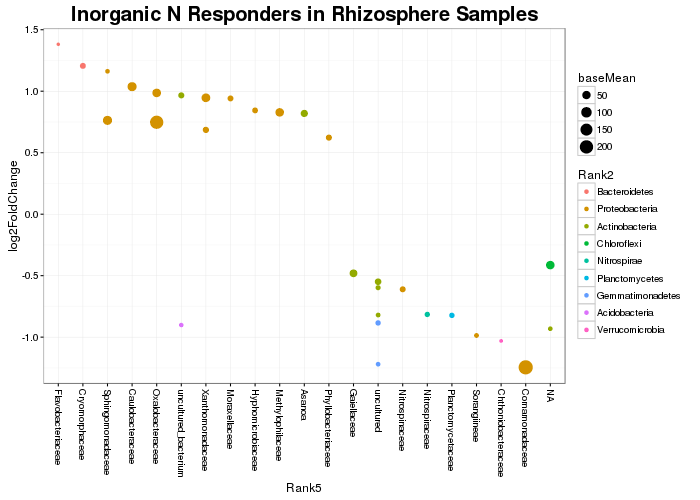

In [194]:
%%R -w 700 -h 500


sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))

x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))

 

p = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() + 
    ggtitle("Inorganic N Responders in Rhizosphere Samples") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5),
    plot.title = element_text(face="bold", size=20))
       


p

In [195]:
%%R
paste(dim(sigtab)[1], "OTUs correlated with inorganic N concentration")

[1] "30 OTUs correlated with inorganic N concentration"


## Notes:
* Few OTUs respond to inorganic N concentration.  It is possible that the interaction between plant and N concentration is important
* Distribution is right skewed, so log transformation of inorganic N concentration is helpful


## Create DeSeq2 object testing for N treatment while controlling for plant
* using trimmed data set for which there is Inorganic N data

In [170]:
%%R

dds = phyloseq_to_deseq2(physeq.plant, ~Plant + Treatment)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(physeq.plant)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

DF$Test = "Ntreat_a"
        NR = rbind(NR, DF)

 [1] "Intercept"     "Plant75.062"   "PlantABUTH"    "PlantAMAPO"   
 [5] "PlantB97"      "PlantECHCG"    "PlantERATE"    "PlantFAGES"   
 [9] "PlantGLYMA"    "PlantMS71"     "PlantOh7B"     "PlantSETFA"   
[13] "TreatmentNneg" "TreatmentNpos"


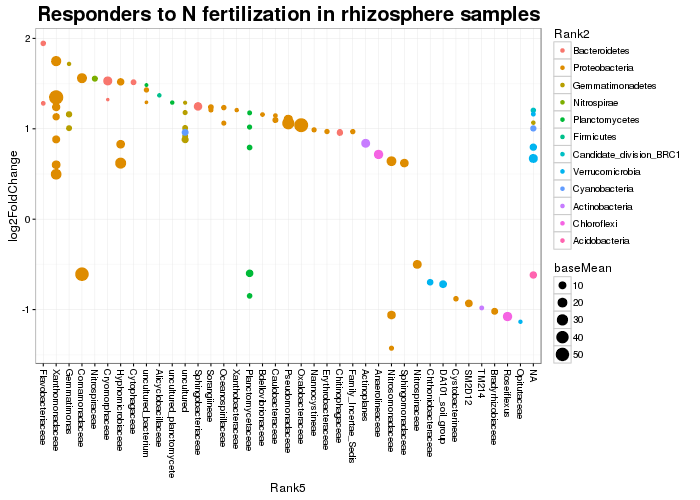

In [171]:
%%R -w 700 -h 500


sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))

x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))

 
NtreatResp1_6 = DF
p = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() + 
    ggtitle("Responders to N fertilization in rhizosphere samples") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5),
    plot.title = element_text(face="bold", size=20))
       
p
    

## Test N treatment effect in entire dataset


In [190]:
%%R
phy = subset_samples(physeq.Full, Plant != "BARE")
dds = phyloseq_to_deseq2(phy, ~Plant + Treatment)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

DF$Test = "Ntreat_b"
        NR = rbind(NR, DF)

 [1] "Intercept"     "Plant75.062"   "PlantABUTH"    "PlantAMAPO"   
 [5] "PlantB73"      "PlantB97"      "PlantECHCG"    "PlantELCOR"   
 [9] "PlantERATE"    "PlantFAGES"    "PlantGLYMA"    "PlantH99"     
[13] "PlantHELAN"    "PlantHp301"    "PlantIl14H"    "PlantKi3"     
[17] "PlantMo18"     "PlantMS71"     "PlantOh7B"     "PlantSETFA"   
[21] "PlantSORBI"    "PlantSORSUD"   "PlantTx303"    "TreatmentNneg"
[25] "TreatmentNpos"
Error in rbind(deparse.level, ...) : 
  numbers of columns of arguments do not match


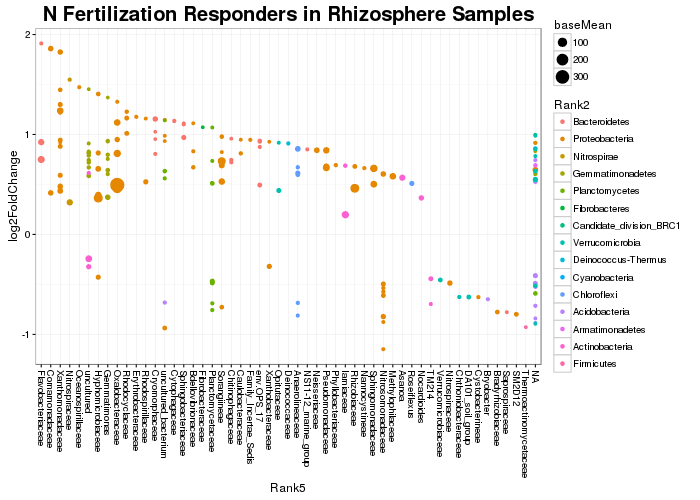

In [191]:
%%R -w 700 -h 500


sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))

x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))

NtreatResp1_8 = DF

p = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() + 
    ggtitle("N Fertilization Responders in Rhizosphere Samples") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5),
    plot.title = element_text(face="bold", size=20))
       
p
    

In [192]:
%%R
paste(dim(sigtab)[1], "OTUs shift in response to nitrogen fertilization")

[1] "181 OTUs shift in response to nitrogen fertilization"


# Make heatmap of OTUs that are responders in N

In [174]:
%%R
head(NR)

          baseMean log2FoldChange     lfcSE       stat     pvalue padj    Rank1
OTU.4087 0.1685120    -0.22324865 0.2137661 -1.0443594 0.29631916   NA Bacteria
OTU.2009 0.7144240    -0.14525582 0.2895074 -0.5017344 0.61585439   NA Bacteria
OTU.5899 0.2775791     0.09253558 0.2546568  0.3633737 0.71632572   NA Bacteria
OTU.4181 0.2164358    -0.37738687 0.2596174 -1.4536272 0.14604968   NA Bacteria
OTU.3052 0.3665593    -0.16911370 0.2674870 -0.6322315 0.52723560   NA Bacteria
OTU.1890 1.0368276    -0.60273821 0.2897294 -2.0803485 0.03749358   NA Bacteria
                 Rank2                Rank3                     Rank4 Rank5
OTU.4087           TM6 uncultured_bacterium                      <NA>  <NA>
OTU.2009           TM6 uncultured_bacterium                      <NA>  <NA>
OTU.5899 Acidobacteria                32-21      uncultured_bacterium  <NA>
OTU.4181 Elusimicrobia          Lineage_IIa      uncultured_bacterium  <NA>
OTU.3052 Elusimicrobia          Lineage_IIa uncultured_soil_

In [178]:
%%R
temp = NR
temp$direction = ifelse(temp$log2FoldChange >= 0, "Pos", "Neg")
temp = filter(temp, padj < 0.05)
temp %>% head

   baseMean log2FoldChange     lfcSE      stat       pvalue        padj
1 53.245384     -0.4139186 0.1175212 -3.522076 4.281808e-04 0.040523564
2  4.443272     -0.9009388 0.2671953 -3.371837 7.466868e-04 0.046052030
3  5.376219     -1.2198273 0.2740771 -4.450672 8.560202e-06 0.005410145
4  9.925462     -0.8839586 0.2612057 -3.384147 7.139978e-04 0.046052030
5 15.452774      1.2064905 0.2794981  4.316632 1.584278e-05 0.005684389
6  2.474040      1.3818673 0.2844800  4.857519 1.188655e-06 0.002132446
     Rank1            Rank2            Rank3             Rank4
1 Bacteria      Chloroflexi           KD4-96              <NA>
2 Bacteria    Acidobacteria       Holophagae         43F-1404R
3 Bacteria Gemmatimonadetes Gemmatimonadales Gemmatimonadaceae
4 Bacteria Gemmatimonadetes Gemmatimonadales Gemmatimonadaceae
5 Bacteria    Bacteroidetes    Flavobacteria  Flavobacteriales
6 Bacteria    Bacteroidetes    Flavobacteria  Flavobacteriales
                 Rank5                Rank6            

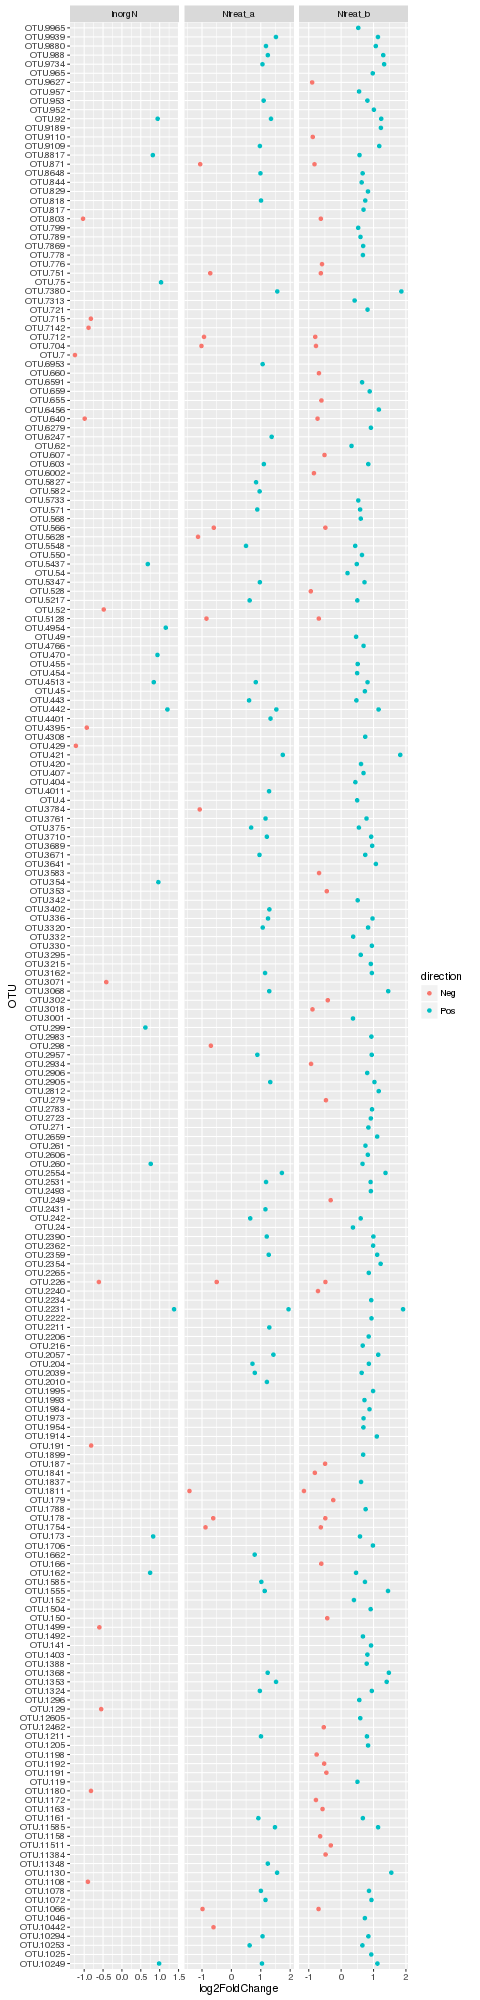

In [188]:
%%R -h 2000

NR$direction = ifelse(NR$log2FoldChange >= 0, "Pos", "Neg")
temp = filter(NR, padj < 0.05)
ggplot(temp, aes(x = log2FoldChange, y = OTU, color = direction)) +
geom_point() + 
facet_grid(. ~ Test, scales='free_x')

# Write table of rhizosphere N responders to file

In [189]:
%%R
write.table(NR, file = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/Nresponders.txt', sep = "\t")


## Format tables

# Test inorganic N concentration in bare soil samples

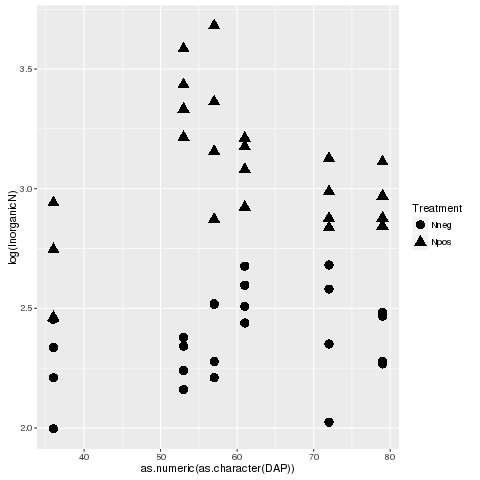

In [110]:
%%R
sd = sample_data(physeq.bare)
p = ggplot(sd, aes(x = as.numeric(as.character(DAP)), y = log(InorganicN), shape = Treatment)) + 
           geom_point(size = 4)
p 

## Test for InorganicN while controlling for date

In [115]:
%%R

dds = phyloseq_to_deseq2(physeq.bare, ~DAP + Rep + log(InorganicN))
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds, independentFiltering = TRUE, parallel = TRUE)

supp = tax_table(physeq.bare)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

 [1] "Intercept"       "DAP36"           "DAP53"           "DAP57"          
 [5] "DAP61"           "DAP72"           "DAP79"           "Rep1"           
 [9] "Rep2"            "Rep3"            "Rep4"            "log.InorganicN."


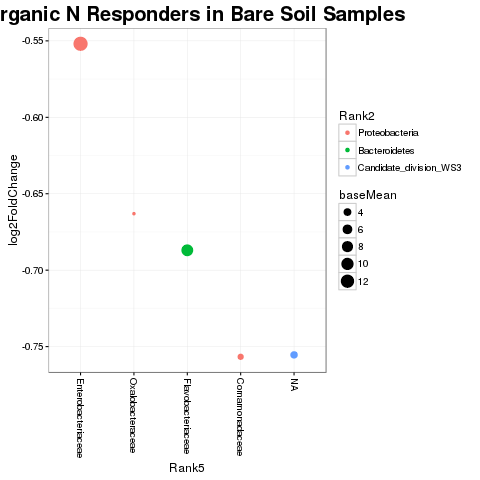

In [116]:
%%R
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))

x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))

 

p = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() + 
    ggtitle("Inorganic N Responders in Bare Soil Samples") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5),
    plot.title = element_text(face="bold", size=20))
       
p

In [117]:
%%R
sigtab = filter(DF, padj < 0.05)

paste(dim(sigtab)[1], "OTUs respond to inorganic N concentration in bare soil samples")

[1] "5 OTUs respond to inorganic N concentration in bare soil samples"


## Test N treatment effect in bare soil


In [118]:
%%R
dds = phyloseq_to_deseq2(physeq.bare, ~DAP + Rep + Treatment)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds, independentFiltering = TRUE, parallel = TRUE)

supp = tax_table(physeq.bare)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

 [1] "Intercept"     "DAP36"         "DAP53"         "DAP57"        
 [5] "DAP61"         "DAP72"         "DAP79"         "Rep1"         
 [9] "Rep2"          "Rep3"          "Rep4"          "TreatmentNneg"
[13] "TreatmentNpos"


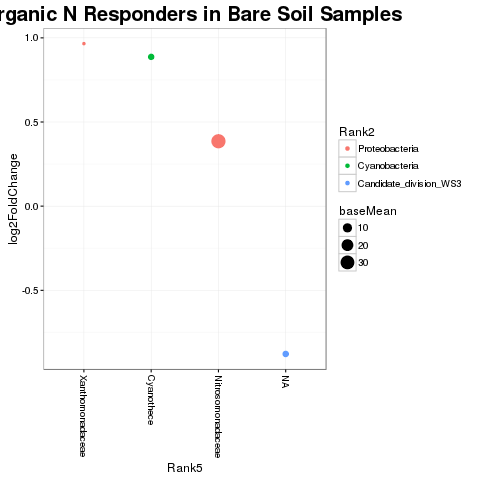

In [119]:
%%R
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))

x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))

 

p = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() + 
    ggtitle("Inorganic N Responders in Bare Soil Samples") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5),
    plot.title = element_text(face="bold", size=20))
       
p
    

In [121]:
%%R
sigtab = filter(DF, padj < 0.05)
paste(dim(sigtab)[1], "OTUs respond to N treatment in bare soil samples")

[1] "4 OTUs respond to N treatment in bare soil samples"


In [122]:
%%R
sigtab

   baseMean log2FoldChange      lfcSE      stat       pvalue        padj
1  3.636690      0.8870216 0.19319561  4.591314 4.404650e-06 0.007233904
2  1.319885      0.9656571 0.18303240  5.275881 1.321202e-07 0.000650956
3 32.370588      0.3859195 0.09219816  4.185762 2.842111e-05 0.035007707
4  3.720877     -0.8779052 0.18449437 -4.758439 1.950962e-06 0.004806194
     Rank1                  Rank2                Rank3            Rank4
1 Bacteria          Cyanobacteria          SubsectionI          FamilyI
2 Bacteria         Proteobacteria  Gammaproteobacteria  Xanthomonadales
3 Bacteria         Proteobacteria   Betaproteobacteria Nitrosomonadales
4 Bacteria Candidate_division_WS3 uncultured_bacterium             <NA>
              Rank5                Rank6                Rank7 Rank8       OTU
1        Cyanothece uncultured_bacterium                 <NA>  <NA>   OTU.621
2  Xanthomonadaceae          Silanimonas uncultured_bacterium  <NA>  OTU.6279
3 Nitrosomonadaceae         Nitrosospira 